In [30]:
import numpy as np
from datasets import get_dataset
import sys 
import matplotlib.pyplot as plt
from tiffwrapper import make_composite
from decoders import get_decoder
import torch
import os
sys.path.insert(0, "../")
from model_builder import get_base_model, get_pretrained_model_v2
from configuration import Configuration 
from DEFAULTS import BASE_PATH
DATASET = "factin"
MODEL = "mae-lightning-small"
WEIGHTS = "MAE_SMALL_STED"
CHECKPOINT = "/home-local/Frederic/segmentation-baselines/mae-lightning-small/factin/pretrained-MAE_SMALL_STED-46" 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
backbone, cfg = get_pretrained_model_v2(MODEL, WEIGHTS)
train_dataset, _, _ = get_dataset(name=DATASET, cfg=cfg)

in_channels 1
--- mae-lightning-small | /home-local/Frederic/baselines/mae-small_STED/pl_checkpoint-999.pth ---

--- Loaded model mae-lightning-small with weights MAE_SMALL_STED ---


numpy.mean(stats, axis=0)=array([0.0225443 , 0.02756524], dtype=float32)


numpy.mean(stats, axis=0)=array([0.01968331, 0.02468607], dtype=float32)


numpy.mean(stats, axis=0)=array([0.01742897, 0.02305424], dtype=float32)


In [32]:
class SegmentationConfiguration(Configuration):
    
    freeze_backbone: bool = True
    num_epochs: int = 300
    learning_rate: float = 1e-4
segmentation_cfg = SegmentationConfiguration()
for key, value in segmentation_cfg.__dict__.items():
        setattr(cfg, key, value)
model = get_decoder(backbone, cfg)
ckpt = torch.load(os.path.join(CHECKPOINT, "result.pt"))["model"]
model.load_state_dict(ckpt)
model = model.to(DEVICE)
model.eval()


===== Loading ViTSegmentationClassifier =====

--- Freezing backbone ---


ViTSegmentationClassifier(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 384, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(app

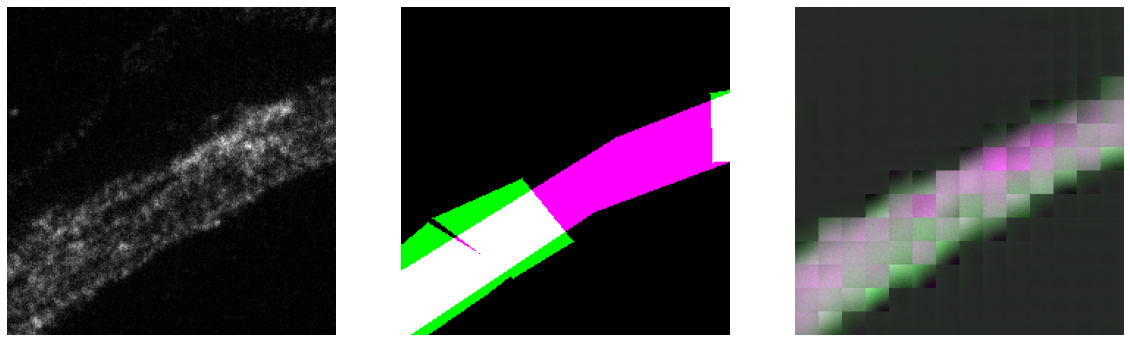

In [41]:
def merge_masks(masks):
    image_rgb = make_composite(masks, luts=["green", "magenta"], ranges=[(masks.min(), masks.max()), (masks.min(), masks.max())])
    return image_rgb

N = len(train_dataset)
indices = np.random.randint(0, N, size=50)

for i in [55]:
    image, mask = train_dataset[i]
    pred = model(image.unsqueeze(0).to(DEVICE)).squeeze().detach().cpu().numpy()
    image = image.squeeze().cpu().numpy()
    mask = mask.cpu().numpy()
    mask = merge_masks(mask)
    pred = merge_masks(pred)
    fig, axs = plt.subplots(1, 3, figsize=(20, 10))
    axs[0].imshow(image, cmap="gray")
    axs[1].imshow(mask)
    axs[2].imshow(pred)
    # axs[0].set_title(i)
    for ax in axs:
        ax.axis("off")
    fig.savefig(f"./factin_example_{i}.pdf", bbox_inches="tight", dpi=1200)
    # plt.show()
